#  XGB Model

In [1]:
import datetime
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn

'''for saving models'''
from joblib import dump, load

In [2]:
# MANIFEST - list of versions on board 
import sys
import os
print(pd.datetime.now())
print('OS: '+os.uname().sysname)
print('Python: '+sys.version)
print('numpy: '+np.__version__)
print('pandas: '+pd.__version__)
print('sklearn: '+sklearn.__version__)

2020-01-29 10:00:04.007338
OS: Linux
Python: 3.7.4 (default, Aug 13 2019, 20:35:49) 
[GCC 7.3.0]
numpy: 1.17.2
pandas: 0.25.1
sklearn: 0.21.3


In [23]:
import xgboost as xgb
xgb.__version__

'0.90'

In [20]:
def xgb_progressbar(rounds=1000):
    """Progressbar for xgboost using tqdm library.
    https://programtalk.com/python-examples/tqdm/
    >>> model = xgb.train(params, X_train, 1000, callbacks=[xgb_progressbar(100), ])
    """
    from tqdm.auto import tqdm
    pbar = tqdm(total=rounds)

    def callback(_, ):
        pbar.update(1)

    return callback

## Data Prep

In [3]:
FOLDER = '../mortality_prediction_docker_model/v2/scratch/'
train_file = FOLDER+'train_all.csv'
train = pd.read_csv(train_file,low_memory = False)
train.shape

(278998, 226)

In [4]:
train.head()

,number_of_visits,visit_duration,gender_concept_id,race_concept_id,ethnicity_concept_id,old,death_in_next_window,visit_concept_name,person_id,race_concept_name,...,procedure_concept_2314215,drug_concept_19033627,procedure_concept_2313850,procedure_concept_2109792,procedure_concept_2003939,condition_concept_81723,procedure_concept_2110916,procedure_concept_2314207,procedure_concept_2003789,observation_concept_40757059
0,4,0,8507,8552.0,NaN,84.0,0,0,0,Unknown,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,0,8507,8557.0,NaN,72.0,0,1,5,Native Hawaiian or Other Pacific Islander,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,0,8532,8527.0,NaN,31.0,0,0,6,White,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,0,8532,8552.0,38003564.0,71.0,0,0,10,Unknown,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2,0,8532,8516.0,NaN,88.0,0,0,12,Black or African American,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
start_mem = train.memory_usage().sum() / 1024**2
print('Memory usage is {:.2f} MB'.format(start_mem))

Memory usage is 481.06 MB


In [6]:
def cols_toint(df):
    df = df.fillna(0)
    df.old = df.old.astype(int)
    for c in df.columns[df.columns.str.startswith('days')]:
        df[c] = df[c].astype(int)
    return df

In [7]:
train = cols_toint(train)

In [8]:
def reduce_mem_usage(df):
    '''https://www.mikulskibartosz.name/how-to-reduce-memory-usage-in-pandas/'''
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object and col_type :
                c_min = df[col].min()
                c_max = df[col].max()
                c_unique = len(df[col].unique())

                if str(col_type)[:3] == 'int':
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min > np.iinfo(np.uint8).min and c_max < np.iinfo(np.uint8).max:
                        df[col] = df[col].astype(np.uint8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif c_min > np.iinfo(np.uint16).min and c_max < np.iinfo(np.uint16).max:
                        df[col] = df[col].astype(np.uint16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min > np.iinfo(np.uint32).min and c_max < np.iinfo(np.uint32).max:
                        df[col] = df[col].astype(np.uint32)                    
                    elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)
                    elif c_min > np.iinfo(np.uint64).min and c_max < np.iinfo(np.uint64).max:
                        df[col] = df[col].astype(np.uint64)
                else:
                    if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                        df[col] = df[col].astype(np.float16)
                    elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
                    else:
                        df[col] = df[col].astype(np.float64)

                if c_min == 0.0 and c_max == 1.0 and c_unique == 2:
                    df[col] = df[col].astype(bool)
                    pass
                
#                 if 2 > c_unique and c_unique < 21: # convert to categorical - needs more work
#                     df[col] = pd.Categorical(df[col])


    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

In [9]:
train = reduce_mem_usage(train)

Memory usage of dataframe is 481.06 MB
Memory usage after optimization is: 66.25 MB
Decreased by 86.2%


In [10]:
train.head()

,number_of_visits,visit_duration,gender_concept_id,race_concept_id,ethnicity_concept_id,old,death_in_next_window,visit_concept_name,person_id,race_concept_name,...,procedure_concept_2314215,drug_concept_19033627,procedure_concept_2313850,procedure_concept_2109792,procedure_concept_2003939,condition_concept_81723,procedure_concept_2110916,procedure_concept_2314207,procedure_concept_2003789,observation_concept_40757059
0,4,0,8507,8552.0,0.0,84,False,0,0,Unknown,...,False,False,False,False,False,False,False,False,False,False
1,1,0,8507,8560.0,0.0,72,False,1,5,Native Hawaiian or Other Pacific Islander,...,False,False,False,False,False,False,False,False,False,False
2,3,0,8532,8528.0,0.0,31,False,0,6,White,...,False,False,False,False,False,False,False,False,False,False
3,1,0,8532,8552.0,38003564.0,71,False,0,10,Unknown,...,False,False,False,False,False,False,False,False,False,False
4,2,0,8532,8512.0,0.0,88,False,0,12,Black or African American,...,False,False,False,False,False,False,False,False,False,False


In [11]:
def find_dup_cols(df_in):
    '''
    Find duplicate columns:
    >>> df = pd.DataFrame([[1,1,4], [2,2,5], [3,3,6]], columns=['a','b','c']); find_dup_cols(df)
    ['b', 'c']
    '''
    from tqdm import tqdm

    df = df_in.copy(deep=True)
    i = 1
    dupes = []
    for c in tqdm(df.columns):
        if c not in df.columns: # a column could have been deleted
            pass
        for d in df.columns[i:]: # for every subsequent column
            if len(pd.Series(list(zip(df[c], df[d]))).unique()) == len(df[c].unique()) == len(df[d].unique()):
                dupes += d
                df = df.drop(d, axis=1)
        i += 1
    return dupes

from doctest import testmod
testmod(name='find_dup_cols')

100%|██████████| 3/3 [00:00<00:00, 569.29it/s]


TestResults(failed=0, attempted=1)

In [12]:
# %%time
# # expensive, don't do this if you don't have time
# find_dup_cols(train)

In [13]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train.race_concept_name = train.race_concept_name.replace(to_replace=0, value='Unknown')
train.race_concept_name = train.race_concept_name.fillna('Unknown')
label_encoder = label_encoder.fit(train.race_concept_name)
train.race_concept_name = label_encoder.transform(train.race_concept_name)

In [14]:
train.describe(include='all').T.fillna('')

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
number_of_visits,278998.0,,,,3.97358,9.90562,1,1,2,3,465
visit_duration,278998.0,,,,0.695471,3.33994,0,0,0,0,138
gender_concept_id,278998.0,,,,8521.07,12.4016,8507,8507,8532,8532,8532
race_concept_id,278998.0,,,,,,0,8512,8528,8560,8656
ethnicity_concept_id,278998.0,,,,2.12587e+07,1.88731e+07,0,0,3.80036e+07,3.80036e+07,3.80036e+07
...,...,...,...,...,...,...,...,...,...,...,...
condition_concept_81723,278998.0,2,False,278893,,,,,,,
procedure_concept_2110916,278998.0,2,False,278957,,,,,,,
procedure_concept_2314207,278998.0,2,False,278048,,,,,,,
procedure_concept_2003789,278998.0,2,False,278967,,,,,,,


In [15]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
number_of_visits,278998.0,3.973584e+00,9.905619e+00,1.0,1.0,2.0,3.0,465.0
visit_duration,278998.0,6.954709e-01,3.339940e+00,0.0,0.0,0.0,0.0,138.0
gender_concept_id,278998.0,8.521065e+03,1.240165e+01,8507.0,8507.0,8532.0,8532.0,8532.0
race_concept_id,278998.0,NaN,NaN,0.0,8512.0,8528.0,8560.0,8656.0
ethnicity_concept_id,278998.0,2.125874e+07,1.887310e+07,0.0,0.0,38003564.0,38003564.0,38003564.0
old,278998.0,7.205466e+01,1.259637e+01,0.0,67.0,73.0,80.0,101.0
visit_concept_name,278998.0,6.089649e-01,1.694314e+00,0.0,0.0,0.0,1.0,65.0
person_id,278998.0,7.581821e+04,4.366814e+04,0.0,38065.0,75703.0,113636.0,151684.0
race_concept_name,278998.0,2.705618e+00,1.667634e+00,0.0,1.0,3.0,4.0,5.0
er_visit_count,278998.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0


In [16]:
train.shape

(278998, 226)

In [17]:
#train = train.drop(train.columns[train.columns.str.startswith('days_since')], axis=1)

In [18]:
X = train.drop(['death_in_next_window','person_id'], axis = 1)
train_features = X.columns.values
y = train[['death_in_next_window']]
X = np.array(X)
y = np.array(y).ravel()

In [19]:
# # there are no duplicates
# train_nodup = train.drop_duplicates()
# train_nodup.shape

## Test

In [27]:
test_file = FOLDER+'test_all.csv'
test = pd.read_csv(test_file,low_memory = False)
test.shape

(28484, 230)

In [28]:
test = cols_toint(test)
test.shape

(28484, 230)

In [29]:
test.race_concept_name = test.race_concept_name.replace(to_replace=0, value='Unknown')
test.race_concept_name = test.race_concept_name.fillna('Unknown')
test.race_concept_name = label_encoder.transform(test.race_concept_name)

In [30]:
#test = test.drop(test.columns[test.columns.str.startswith('days_since')], axis=1)

In [31]:
X_test = test.drop(['person_id'], axis = 1)
X_test = X_test[train_features]  # order the test columns like train
test_features = X_test.columns.values
X_test = np.array(X_test)

In [32]:
person = pd.read_csv(FOLDER+'../infer/person.csv')
visit = pd.read_csv(FOLDER+'../infer/visit_occurrence.csv')
cols = ['person_id','visit_start_date']
visit = visit[cols]
death = pd.read_csv(FOLDER+'../infer/death.csv')
cols = ['person_id','death_date']
death = death[cols]
visit_death = pd.merge(death,visit,on=['person_id'],how='inner')
visit_death['death_date'] = pd.to_datetime(visit_death['death_date'], format='%Y-%m-%d')
visit_death['visit_start_date'] = pd.to_datetime(visit_death['visit_start_date'], format='%Y-%m-%d')
visit_death['last_visit_death'] = visit_death['death_date'] - visit_death['visit_start_date']
visit_death['last_visit_death'] = visit_death['last_visit_death'].apply(lambda x: x.days)
visit_death = visit_death.loc[visit_death['last_visit_death'] <= 180]
visit_death.drop_duplicates(subset=['person_id'], keep = 'first',inplace = True)
visit_death = visit_death[['person_id','visit_start_date']]
visit_death.columns = ['person_id','prediction_date']
visit_death['death'] = np.ones(visit_death.shape[0])
visit_live = visit[~visit.person_id.isin(visit_death.person_id)]
visit_live = visit_live[['person_id','visit_start_date']]

In [33]:
visit_death.death = visit_death.death.astype(int)
visit_death = visit_death.set_index('person_id')
visit_death = visit_death.drop('prediction_date', axis=1)
visit_death.head()

,death
person_id,
1407,1
110,1
20824,1
29118,1
12669,1


In [34]:
visit_death.shape

(130, 1)

In [35]:
y_test = pd.DataFrame(index=person.person_id)
y_test['death'] = 0
y_test.death = visit_death.death
y_test = y_test.fillna(0)
y_test = y_test.astype(int)
y_test.shape

(28488, 1)

In [36]:
y_test.head()

,death
person_id,
9879,0
640,0
35370,0
11594,0
24438,0


In [37]:
y_test.death.sum()

130

## XGB Model

In [25]:
params = {
    'eval_metric': ['error', 'auc'],
    'tree_method' : 'auto',
    'random_state' : 1234,
    'reg_lambda' : 1.0,
    'min_child_weight' : 1.0,
    'max_bin' : 256,
    'min_split_loss' : 0.01,
    'max_depth' : 10,
    'reg_alpha' : 0.0,
    'colsample_bylevel' : 1.0,
    'scale_pos_weight' : 1.0,
    'max_delta_step' : 0.0,
    'learning_rate' : 0.05,
    'n_estimators' : 1000,
    'num_parallel_tree' : 1,
    'colsample_bytree' : 0.5,
    'subsample' : 1.0,
    'n_jobs': -1.0,
}

num_round = 2000

In [26]:
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
# X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=1234, stratify=y)

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=1234)

for train_index, valid_index in sss.split(X, y):
    X_train, X_valid = X[train_index], X[valid_index]
    y_train, y_valid = y[train_index], y[valid_index]

In [28]:
# Convert our data into XGBoost format
evals_result ={}
d_train = xgb.DMatrix(X_train, y_train, feature_names=train_features)
d_valid = xgb.DMatrix(X_valid, y_valid,  feature_names=train_features)
watchlist = [(d_train, 'train'), (d_valid, 'valid')]

xgb_model = xgb.train(params=params, dtrain=d_train, num_boost_round=num_round, 
                      evals=watchlist, evals_result=evals_result, 
                      early_stopping_rounds=100, verbose_eval=False,
                      callbacks=[xgb_progressbar(num_round),])

print(xgb_model.best_score, xgb_model.best_iteration, xgb_model.best_ntree_limit)

0.629595 28 29


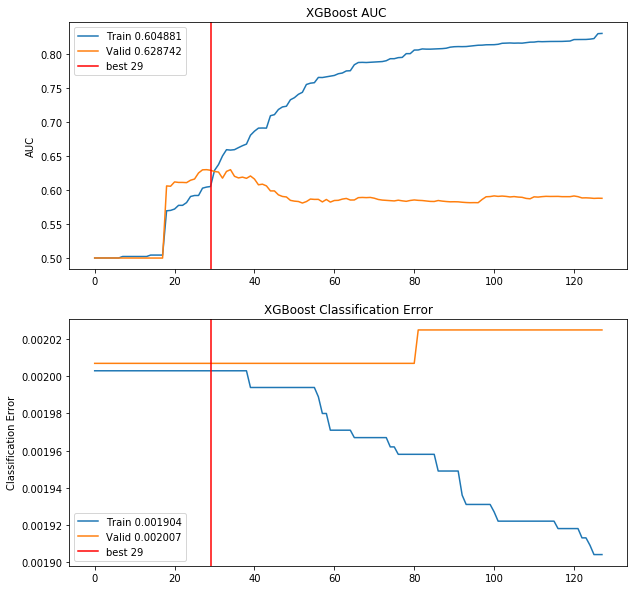

In [29]:
# plot learning curve
epochs = len(evals_result['train']['auc'])
x_axis = range(0, epochs)
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10,10))
ax1.plot(x_axis, evals_result['train']['auc'], label='Train '+str(evals_result['train']['auc'][xgb_model.best_ntree_limit]))
ax1.plot(x_axis, evals_result['valid']['auc'], label='Valid '+str(evals_result['valid']['auc'][xgb_model.best_ntree_limit]))
ax1.ticklabel_format(useOffset=False, style='plain')
ax1.axvline(x=xgb_model.best_ntree_limit, color='r', label='best '+str(xgb_model.best_ntree_limit))
ax1.legend()
ax1.set_ylabel('AUC')
ax1.set_title('XGBoost AUC ')
ax2.plot(x_axis, evals_result['train']['error'], label='Train '+str(evals_result['train']['error'][-1]))
ax2.plot(x_axis, evals_result['valid']['error'], label='Valid '+str(evals_result['valid']['error'][xgb_model.best_ntree_limit]))
ax2.ticklabel_format(useOffset=False, style='plain')
ax2.axvline(x=xgb_model.best_ntree_limit, color='r', label='best '+str(xgb_model.best_ntree_limit))
ax2.legend()
ax2.set_ylabel('Classification Error')
ax2.set_title('XGBoost Classification Error')
plt.show()

## Eval Test - this is broken ??? as y_test isn't properly mapped

In [64]:
# Predict on test data
d_test = xgb.DMatrix(X_test, y_test, feature_names=test_features)

preds = xgb_model.predict(d_test, ntree_limit=xgb_model.best_ntree_limit)

In [66]:
y_scores = preds

In [67]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import average_precision_score

In [68]:
print('AUC =',roc_auc_score(y_test, y_scores))

AUC = 0.5


In [69]:
# fig, ax = plt.subplots()
# plot_roc_curve(xgb_model, X_test, y_test, ax=ax)
# ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
#         label='Chance', alpha=.8)

# ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
#        title="AUC")
# ax.legend(loc="lower right")
# plt.show()

In [70]:
from sklearn import metrics
def buildROC(target_test,test_preds):
    '''Compute micro-average ROC curve and ROC area'''
    fpr, tpr, threshold = metrics.roc_curve(target_test, test_preds)
    roc_auc = metrics.auc(fpr, tpr)
    plt.rcParams["figure.figsize"] = (8,8)

    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.title('AUC')
    plt.show()

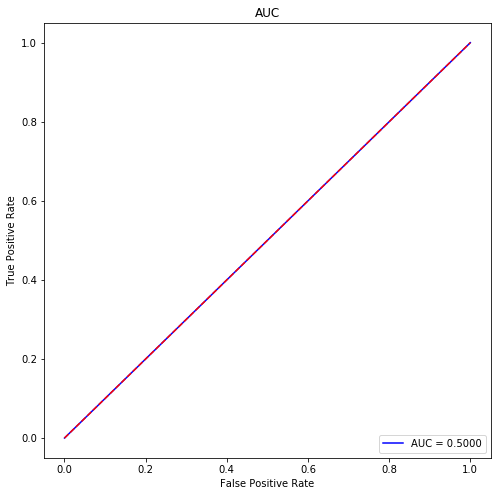

In [71]:
buildROC(y_test,preds)

In [72]:
# !pip install scikit-plot

In [73]:
# import scikitplot as skplt
# plt.rcParams["figure.figsize"] = (10,10)
# skplt.metrics.plot_roc(y_test, preds)

In [74]:
average_precision = average_precision_score(y_test, y_scores)
print('PRAUC = ', average_precision)

PRAUC =  0.004563324908733502


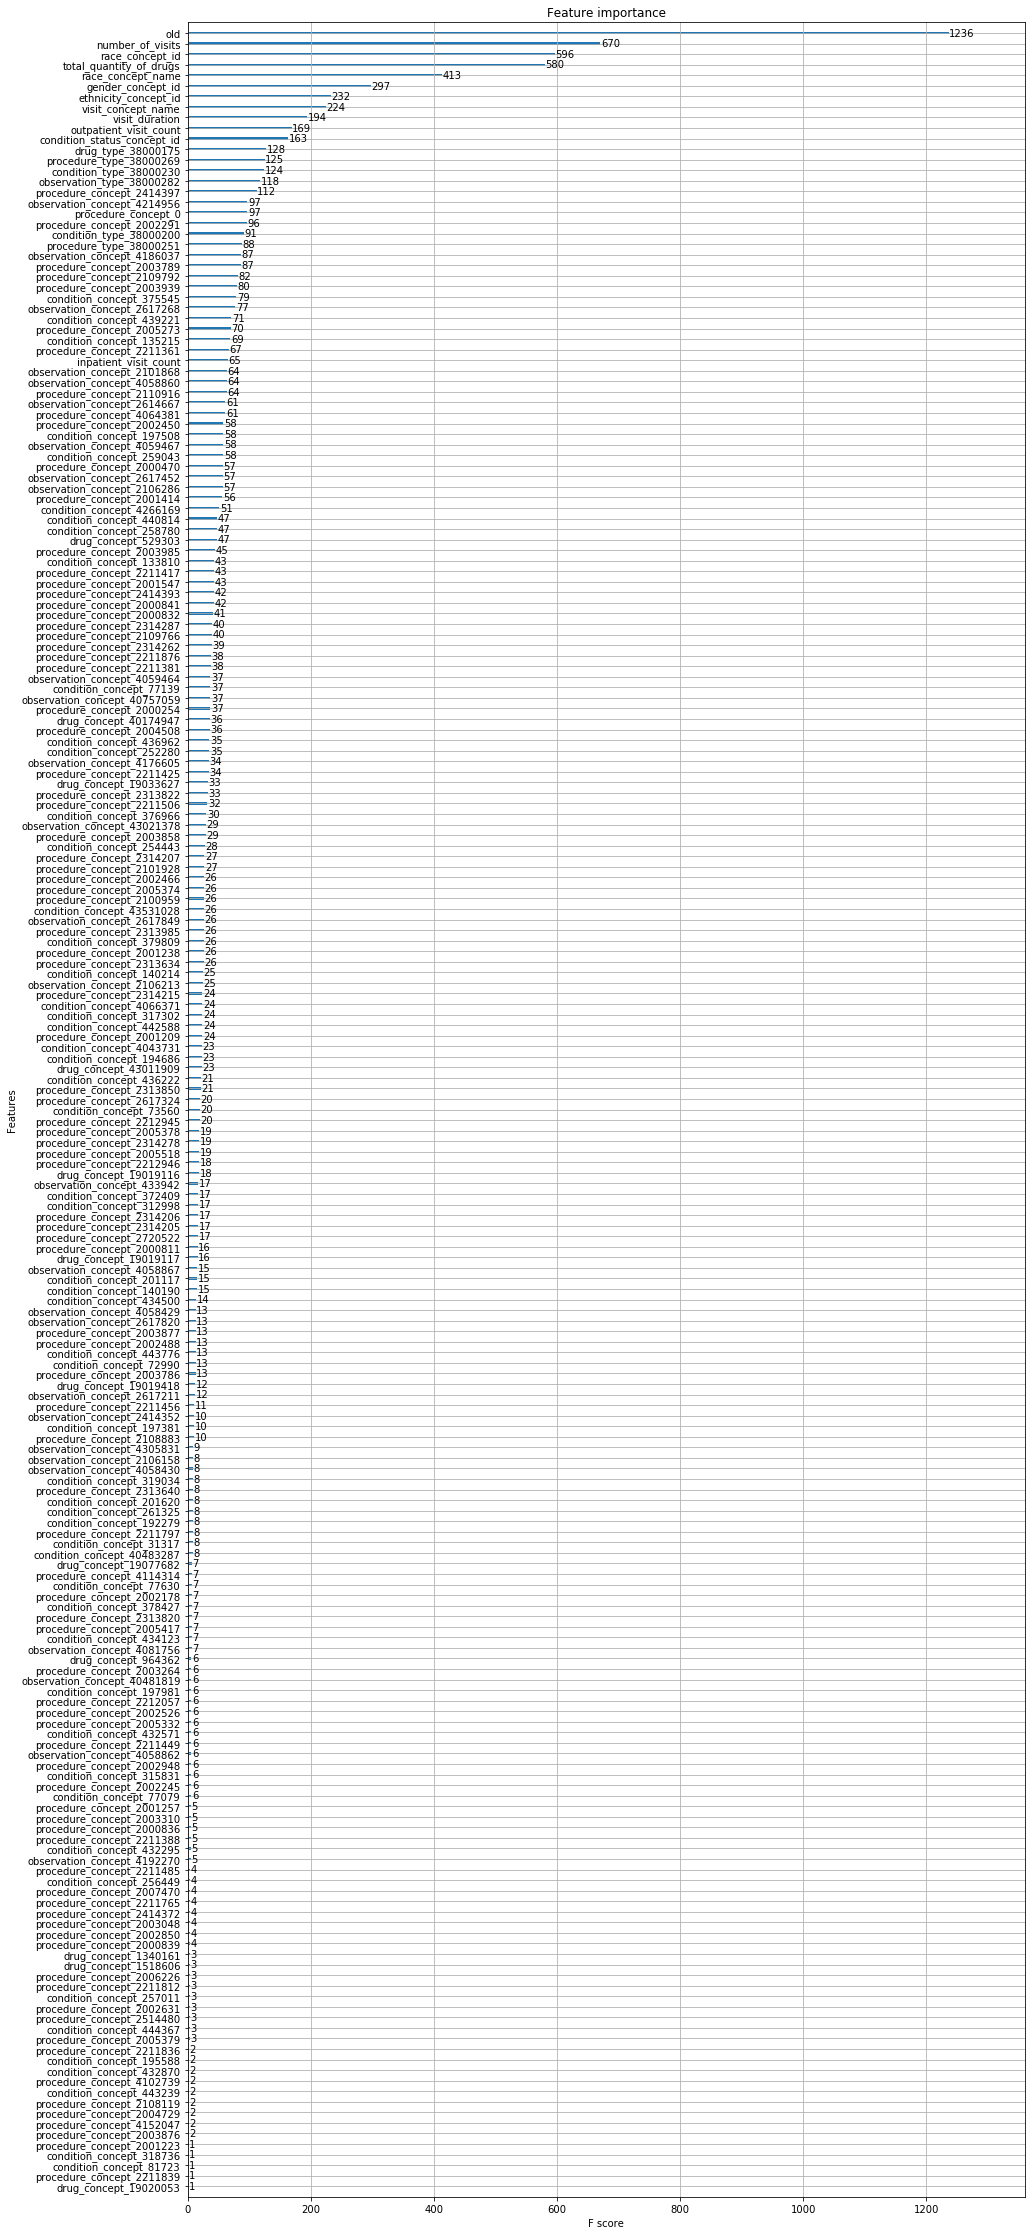

In [48]:
plt.rcParams["figure.figsize"] = (15,40)
ax = xgb.plot_importance(xgb_model)

## Full train

In [19]:
params = {
    'eval_metric': 'auc',
    'tree_method' : 'auto',
    'random_state' : 1234,
    'reg_lambda' : 1.0,
    'min_child_weight' : 1.0,
    'max_bin' : 256,
    'min_split_loss' : 0.01,
    'max_depth' : 10,
    'reg_alpha' : 0.0,
    'colsample_bylevel' : 1.0,
    'scale_pos_weight' : 1.0,
    'max_delta_step' : 0.0,
    'learning_rate' : 0.05,
    'n_estimators' : 1000,
    'num_parallel_tree' : 1,
    'colsample_bytree' : 0.5,
    'subsample' : 1.0,
    'n_jobs': -1.0,
}

num_round = 100

In [24]:
df_preds = pd.DataFrame()
evals_result ={}

d_train_full = xgb.DMatrix(X, y, feature_names=train_features)
watchlist = [(d_train_full, 'train_full')]

xgb_model = xgb.train(params, d_train_full, num_round, watchlist,
                      early_stopping_rounds=50, maximize=True, 
                      verbose_eval=False, callbacks=[xgb_progressbar(num_round), ])

print(xgb_model.best_score, xgb_model.best_ntree_limit)

0.764242 100


In [58]:
model_file = 'xgb_model.joblib'
dump(xgb_model, model_file)

['xgb_model.joblib']

In [59]:
xgb_model_2 = load(model_file)
type(xgb_model_2)